In [19]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [2]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [3]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [4]:
model = DecisionTreeClassifier(random_state=42)

In [5]:
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 20), # profundidade
    'min_samples_split': np.arange(2, 20),  # mínimo de amostras p divisao
    'min_samples_leaf': np.arange(1, 20),  # mínimo de amostras em cada folha
    'max_features': ['auto', 'sqrt', 'log2', None]  # núm de atributos a considerar
}

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=scoring,
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [8]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
115 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
79 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,...
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])},
                   random_state=42, refit='f1_macro',
                   scoring={'accuracy': 'accuracy',
                            'f1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                            'precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                            'recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
                   verbose=2)

In [9]:
best_params = random_search.best_params_
print("Melhores hiperparâmetros encontrados:", best_params)

Melhores hiperparâmetros encontrados: {'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(2), 'max_features': None, 'max_depth': np.int64(3), 'criterion': 'entropy'}


In [12]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, search):
    results = search.cv_results_
    
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]
    
    param_cols = ['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features']
    sorted_indices = np.argsort(results['rank_test_f1_macro'])[:filter_top_n] if filter_top_n else slice(None)
    
    plot_data = []
    for idx in sorted_indices:
        param_values = tuple(results[col][idx] for col in param_cols)
        for metric in metrics:
            plot_data.append((param_values, metric, results[metric][idx]))
    
    plot_df = pd.DataFrame(plot_data, columns=['params', 'metric', 'score'])
    
    plt.figure(figsize=(12, 8))
    for (combo, group) in plot_df.groupby('params'):
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")
    
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics - Decision Tree (Balanced)")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

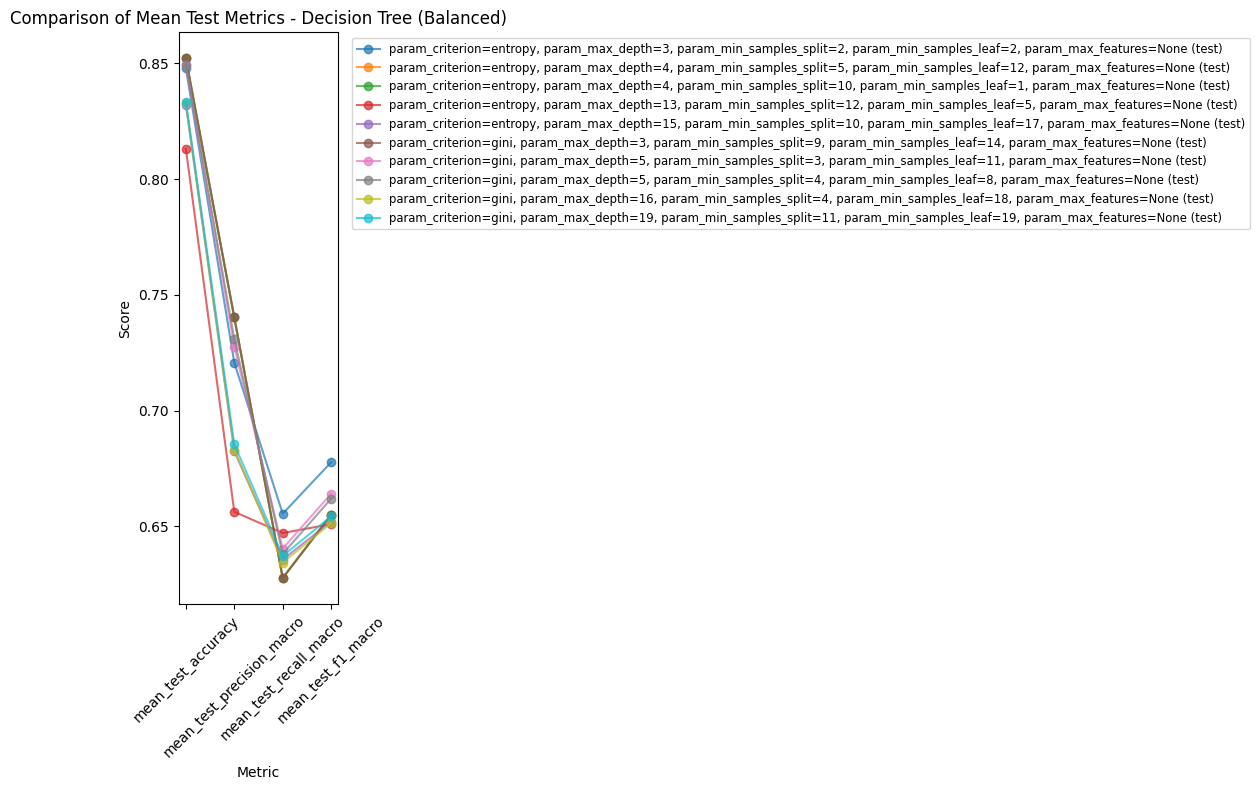

In [14]:
view_test_metrics(False, 10, random_search)

In [15]:
y_pred_cv = cross_val_predict(random_search.best_estimator_, X_train, y_train, cv=cv, n_jobs=-1)

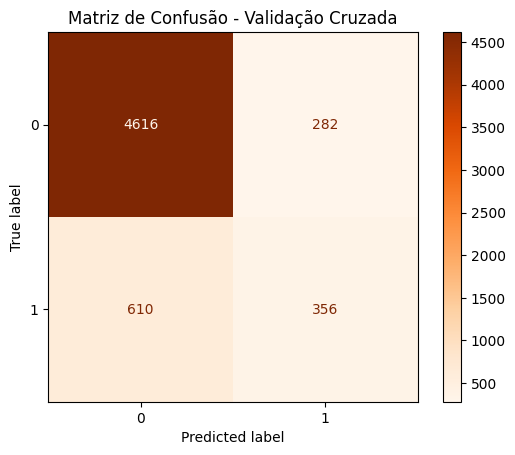

In [16]:
cm_cv = confusion_matrix(y_train, y_pred_cv)
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=random_search.best_estimator_.classes_)
disp_cv.plot(cmap=plt.cm.Oranges)
plt.title("Matriz de Confusão - Validação Cruzada")
plt.show()

In [17]:
y_pred = random_search.best_estimator_.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      2100
           1       0.50      0.36      0.42       414

    accuracy                           0.84      2514
   macro avg       0.69      0.65      0.66      2514
weighted avg       0.82      0.84      0.83      2514



- modelo muito bom para a classe 0 (maioria), com alta precisão e recall.
- dificuldades na classe 1 (minoria), com baixo recall (34%).

In [18]:
joblib.dump(random_search.best_estimator_, 'models/decision_tree.pkl')

['models/decision_tree.pkl']